In [1]:
import gym
from gym.envs.toy_text.blackjack import sum_hand

In [2]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

In [3]:
env = gym.make('Blackjack-v0', natural=True)

### Часть первая, с блекджеком и стратегиями

Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

In [4]:
wins = 0
n_games = 10000
for _ in range(n_games):
    state = env.reset()
    done = False
    while not done:
        if sum_hand(env.player) < 19:
            action = 1
        else:
            action = 0
        state, reward, done, _ = env.step(action=action)

    if reward > 0:
        wins += reward
wins/n_games

0.383

При такой стратегии получаем вероятность ~38%

Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.

In [5]:
gamma = 1.0
epsilon=0.05
actions = [0, 1]

In [6]:
def evaluate_policy(Q, episodes=1000):
    wins = 0
    for _ in range(episodes):
        state = env.reset()
        done = False
        while not done:
            action = np.argmax(Q[state])
            state, reward, done, _ = env.step(action=action)
        if reward > 0:
            wins += reward
    return wins / episodes

In [7]:
def get_action(Q, state, epsilon):
    random_action = np.random.choice([1, 0])
    best_action = np.argmax(Q[state])
    return np.random.choice([best_action, random_action], p=[1 - epsilon, epsilon])


In [8]:
def monte_carlo(gamma=1.0, epsilon=0.1, episodes=5000, evaluate=False):

    Q = defaultdict(lambda: np.zeros(2))

    state_action_count = defaultdict(float)

    evaluations = []
    for i in range(episodes):
        if evaluate and i % 1000 == 0:
            evaluations.append(evaluate_policy(Q))
        episode = []
    
        # lets start a game!
        state = env.reset()
        done = False
        while not done:
            action = get_action(Q, state, epsilon)
            new_state, reward, done, _ = env.step(action=action)
            episode.append((state, action, reward))
        
            state = new_state


        G = 0
        for s, a, r in reversed(episode):
            new_s_a_count = state_action_count[(s, a)] + 1
            
            G = r + gamma * G
            state_action_count[(s, a)] = new_s_a_count
            Q[s][a] = Q[s][a] + (G - Q[s][a]) / new_s_a_count
            
    return Q, evaluations

In [9]:
Q, evaluations = monte_carlo(episodes=100000, evaluate=True, epsilon=0.05)

Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.


Среднее: 0.436


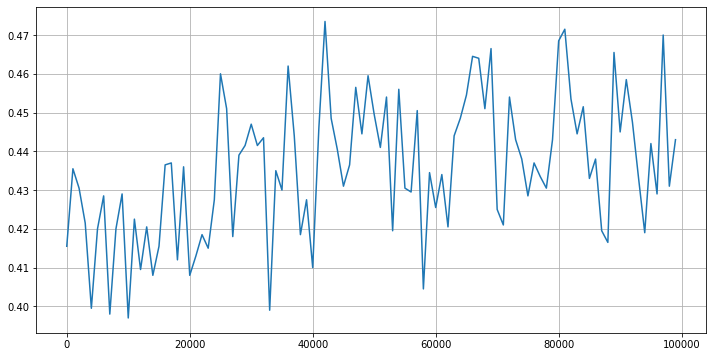

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
line1 = ax.plot([i * 1000 for i in range(len(evaluations))], evaluations, label="Средние награды", color="C0")
ax.grid(True)
avg = round(sum(evaluations)/len(evaluations), 3)
print(f"Среднее: {avg}")

### Часть вторая, удвоенная

Перепишем функции с дополнительным actions

In [11]:
def evaluate_policy(Q, episodes=1000):
    wins = 0
    for _ in range(episodes):
        state = env.reset()
        done = False
        while not done:
            action = np.argmax(Q[state])
            if action == 2 : ##double
                state, reward, done, _ = env.step(action=1)
                done = True
                reward *= 2
            else:
                state, reward, done, _ = env.step(action=action) 
        if reward > 0:
            wins += reward
    return wins / episodes

In [12]:
def get_action(Q, state, epsilon):
    random_action = np.random.choice([1, 0, 2])
    best_action = np.argmax(Q[state])
    return np.random.choice([best_action, random_action], p=[1 - epsilon, epsilon])

In [16]:
def monte_carlo(gamma=1.0, epsilon=0.1, episodes=5000, evaluate=False):

    Q = defaultdict(lambda: np.zeros(3))

    state_action_count = defaultdict(float)

    evaluations = []
    for i in range(episodes):
        if evaluate and i % 1000 == 0:
            evaluations.append(evaluate_policy(Q))
        episode = []

        state = env.reset()
        done = False
        while not done:
            action = get_action(Q, state, epsilon)
            if action == 2 : ##double
                new_state, reward, done, _ = env.step(action=1)
                done = True
                reward *= 2
            else:
                new_state, reward, done, _ = env.step(action=action)
            episode.append((state, action, reward))
        
            state = new_state


        G = 0
        for s, a, r in reversed(episode):
            new_s_a_count = state_action_count[(s, a)] + 1
            
            G = r + gamma * G
            state_action_count[(s, a)] = new_s_a_count
            Q[s][a] = Q[s][a] + (G - Q[s][a]) / new_s_a_count
            
    return Q, evaluations

In [19]:
Q_double, evaluations = monte_carlo(episodes=500000, evaluate=True, epsilon=0.1)

Среднее: 0.35


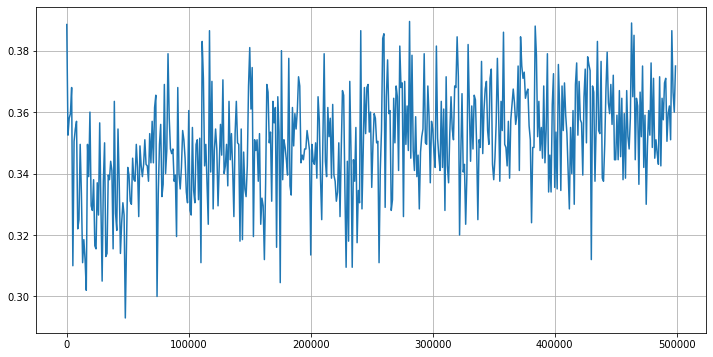

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
line1 = ax.plot([i * 1000 for i in range(len(evaluations))], evaluations, label="Средние награды", color="C0")
ax.grid(True)
avg = round(sum(evaluations)/len(evaluations), 3)
print(f"Среднее: {avg}")

Пока вышло даже хуже, чем самая базовая стратегия, но в целом по графику видно, что он медленно растет.
Возможно если поучить подольше, что-то да выйдет